In [ ]:
# A- Employed libraries

# A-1- PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

# A-2- torchvision libraries
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

# A-3- Required evaluation

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# A-4- Redundant imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [ ]:
# B- transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1,1]
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
# C- Describing train dataset
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
# D- Test dataset
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
# E- Extracts the first image
for i, (X_train, y_train) in enumerate(train_dataset):
    break

In [ ]:
# F- Create a rank-4 tensor to be passed into the model

x = X_train.view(1,1,28,28)
print(x.shape)

torch.Size([1, 1, 28, 28])


In [ ]:
# G- cnn model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
# H- Computing Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
model = CNN().to(device)
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
# I- Loss function and Optimizing

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# J- Training model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 0.5789
Epoch 2/10, Loss: 0.3856
Epoch 3/10, Loss: 0.3273
Epoch 4/10, Loss: 0.2933
Epoch 5/10, Loss: 0.2671
Epoch 6/10, Loss: 0.2515
Epoch 7/10, Loss: 0.2310
Epoch 8/10, Loss: 0.2179
Epoch 9/10, Loss: 0.2037
Epoch 10/10, Loss: 0.1939


In [ ]:
# K- Testing model
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 91.32%


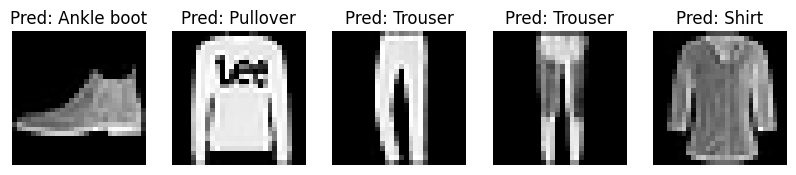

In [ ]:
#- L-Visulaizating 5 first image in test dataset

import numpy as np

# Get a single batch
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Predict
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot first 5 images
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
classes = train_dataset.classes

for i in range(5):
    axes[i].imshow(images[i].cpu().squeeze(), cmap="gray")
    axes[i].set_title(f"Pred: {classes[predicted[i]]}")
    axes[i].axis("off")

plt.show()